## Fruit Image Classifier - Imports & Preprocessing


In [1]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# src imports
from gpu_utils import CheckGPU, CheckCUDA, CheckGPUBrief
from dataset_counter import CountDataset

print("✅ All libraries and custom modules imported successfully!")

✅ All libraries and custom modules imported successfully!


#### Detect GPU Available, Details, Cuda, and cuDNN

In [2]:
# From 
CheckGPU()
CheckCUDA()

🖥️  GPU INFORMATION
✅ GPU Detected         : NVIDIA GeForce RTX 2060
   • Device ID          : 0
   • Compute Capability : 7.5
   • Multiprocessors    : 30
   • Total VRAM         : 6.00 GB
   • VRAM Allocated     : 0.00 GB
   • VRAM Reserved      : 0.00 GB
   • Active Device      : cuda

⚡ CUDA / PYTORCH INFORMATION
✅ CUDA Available       : True
   • PyTorch CUDA Ver.  : 11.8
   • PyTorch Version    : 2.7.1+cu118
✅ cuDNN Version        : 90100
   • CUDA Device Count  : 1
   • Device 0 Name     : NVIDIA GeForce RTX 2060


### Global Configuration Variables

In [3]:
# Dataset directory
DATASET_DIR = "../dataset"

# Data split ratios
TRAIN_RATIO = 0.7
VAL_RATIO = 0.15
TEST_RATIO = 0.15

# Augmentation settings (set to False to disable any data augmentation)
USE_AUGMENTATION = True

USE_WEIGHTED_SAMPLER = True

# Normalization values (commonly used for RGB datasets like ImageNet)
# Can adjust this if want to compute the mean/std of the dataset (currently default)
NORMALIZE_MEAN = [0.485, 0.456, 0.406]
NORMALIZE_STD = [0.229, 0.224, 0.225]

# Image settings
IMG_HEIGHT = 224
IMG_WIDTH = 224

# Batch Size & Classes
BATCH_SIZE = 32
NUM_CLASSES = 5

MODEL_SAVE_PATH = "resnet50_fruit_classifier.pth"

# Seed for reproducibility
SEED = 42

#  SET RANDOM SEEDS
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

#### Dataset Information

In [4]:
dataset_info = CountDataset(DATASET_DIR)


📊 DATASET SUMMARY
Class       count       ratio     needed        size_mb
Apple        5061      1.0000          0      229.93 MB
Banana       5061      1.0000          0      153.37 MB
Grapes       5061      1.0000          0      641.90 MB
Mango        4172      0.8243        889      200.80 MB
Orange       2788      0.5509       2273      360.60 MB
total_images  22143
max_class_count   5061
total_size_mb                                   1586.59 MB


### DEFINE TRANSFORMS & DATA AUGMENTATION

In [5]:
if USE_AUGMENTATION:
    train_transforms = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.RandomResizedCrop((IMG_HEIGHT, IMG_WIDTH), scale=(0.8, 1.0)),
        transforms.ToTensor(),
        transforms.Normalize(mean=NORMALIZE_MEAN, std=NORMALIZE_STD)
    ])
else:
    train_transforms = transforms.Compose([
        transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
        transforms.ToTensor(),
        transforms.Normalize(mean=NORMALIZE_MEAN, std=NORMALIZE_STD)
    ])

val_test_transforms = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor(),
    transforms.Normalize(mean=NORMALIZE_MEAN, std=NORMALIZE_STD)
])

#### LOAD FULL DATASET & TRAIN/VAL/TEST SPLIT

In [6]:
# Load dataset *without transforms* first
full_dataset = datasets.ImageFolder(root=DATASET_DIR)
num_total = len(full_dataset)
print(f"✅ Full dataset loaded successfully from '{DATASET_DIR}' ({num_total} total samples).")

# Split indices
train_size = int(TRAIN_RATIO * num_total)
val_size = int(VAL_RATIO * num_total)
test_size = num_total - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size]
)

print(f"✅ Dataset successfully split:")
print(f"   🔹 Train: {train_size} samples")
print(f"   🔹 Validation: {val_size} samples")
print(f"   🔹 Test: {test_size} samples")


✅ Full dataset loaded successfully from '../dataset' (22143 total samples).
✅ Dataset successfully split:
   🔹 Train: 15500 samples
   🔹 Validation: 3321 samples
   🔹 Test: 3322 samples


#### CLASS WEIGHTS FOR IMBALANCED DATA

In [7]:
# Compute class distribution and weights
class_counts = np.bincount([label for _, label in full_dataset.samples])
class_weights = 1.0 / class_counts
print(f"Class counts: {class_counts}")
print(f"Class weights: {class_weights}")

# Sampler for training (optional)
if USE_WEIGHTED_SAMPLER:
    train_targets = [full_dataset.samples[i][1] for i in train_dataset.indices]
    sample_weights = [class_weights[t] for t in train_targets]
    print("Weighted sampler initialized for training data.")
else:
    print("Weighted sampler disabled.")

Class counts: [5061 5061 5061 4172 2788]
Class weights: [0.00019759 0.00019759 0.00019759 0.00023969 0.00035868]
Weighted sampler initialized for training data.


#### Re-assign transforms per subset

In [8]:
# Re-assign transforms per subset
train_dataset.dataset.transform = train_transforms
val_dataset.dataset.transform = val_test_transforms
test_dataset.dataset.transform = val_test_transforms

print("✅ Transforms successfully assigned to train/val/test datasets.")

✅ Transforms successfully assigned to train/val/test datasets.


#### Dataloaders

In [9]:
if USE_WEIGHTED_SAMPLER:
    sampler = WeightedRandomSampler(
        sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        sampler=sampler
    )
    print(f"✅ Train DataLoader initialized with WeightedRandomSampler ({len(train_dataset)} samples).")
else:
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True
    )
    print(f"✅ Train DataLoader initialized with shuffle=True ({len(train_dataset)} samples).")

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)
print(f"✅ Validation DataLoader initialized ({len(val_dataset)} samples).")

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)
print(f"✅ Test DataLoader initialized ({len(test_dataset)} samples).")


✅ Train DataLoader initialized with WeightedRandomSampler (15500 samples).
✅ Validation DataLoader initialized (3321 samples).
✅ Test DataLoader initialized (3322 samples).


#### PRINT SUMMARY

In [10]:
print(f"📊 Total images: {num_total}")
print(f"    Train: {train_size}")
print(f"    Val:   {val_size}")
print(f"    Test:  {test_size}")
print(f"🖼️ Image size: {IMG_HEIGHT} x {IMG_WIDTH}")
print(f"🧪 Augmentation: {'ENABLED' if USE_AUGMENTATION else 'DISABLED'}")
print(f"⚖️ Weighted Class Sampler: {'ENABLED' if USE_WEIGHTED_SAMPLER else 'DISABLED'}")
print(f"    Class counts: {class_counts.tolist()}")
print(f"    Class weights: {class_weights.tolist()}")
print(f"🧪 Batch size: {BATCH_SIZE}")

📊 Total images: 22143
    Train: 15500
    Val:   3321
    Test:  3322
🖼️ Image size: 224 x 224
🧪 Augmentation: ENABLED
⚖️ Weighted Class Sampler: ENABLED
    Class counts: [5061, 5061, 5061, 4172, 2788]
    Class weights: [0.00019758940920766647, 0.00019758940920766647, 0.00019758940920766647, 0.00023969319271332693, 0.0003586800573888092]
🧪 Batch size: 32


#### MODEL TRAINING KEY VARIABLES

In [ ]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
CHANNELS = 3 # NOT USED
NUM_CLASSES = len(class_counts)
LEARNING_RATE = 0.0001
EPOCHS = 20

# Training history dictionary (global)
history = {
    "train_loss": [],
    "val_loss": [],
    "train_acc": [],
    "val_acc": []
}

#### Load the Pretrained ResNet50 Base

In [12]:
# Load a pre-trained ResNet50 model
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
print("✅ Pre-trained ResNet50 model loaded successfully (weights: IMAGENET1K_V1).")

# Replace the final fully connected layer to match your number of classes
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, NUM_CLASSES)
print(f"✅ Final fully connected layer replaced: {in_features} → {NUM_CLASSES} classes.")

# Move model to GPU if available
CheckCUDA()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(f"✅ Model moved to device: {device.type.upper()}")


✅ Pre-trained ResNet50 model loaded successfully (weights: IMAGENET1K_V1).
✅ Final fully connected layer replaced: 2048 → 5 classes.

⚡ CUDA / PYTORCH INFORMATION
✅ CUDA Available       : True
   • PyTorch CUDA Ver.  : 11.8
   • PyTorch Version    : 2.7.1+cu118
✅ cuDNN Version        : 90100
   • CUDA Device Count  : 1
   • Device 0 Name     : NVIDIA GeForce RTX 2060
✅ Model moved to device: CUDA


#### LOSS & OPTIMIZER

In [13]:
# Use CrossEntropyLoss (can apply class weights if dataset is imbalanced)
class_weights_tensor = torch.FloatTensor(class_weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
print(f"✅ Loss function initialized: CrossEntropyLoss with class weights on {device.type.upper()}.")

# Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(f"✅ Optimizer initialized: Adam (lr={LEARNING_RATE}).")

# Optional: Learning rate scheduler (optional but useful)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
print(f"✅ Learning rate scheduler initialized: StepLR(step_size=7, gamma=0.1).")


✅ Loss function initialized: CrossEntropyLoss with class weights on CUDA.
✅ Optimizer initialized: Adam (lr=0.0001).
✅ Learning rate scheduler initialized: StepLR(step_size=7, gamma=0.1).


#### Model Summary

In [14]:
print(f"""
✅ Model setup complete:
------------------------
🔹 Architecture: ResNet50
🔹 Input size: {IMG_HEIGHT}x{IMG_WIDTH}
🔹 Classes: {NUM_CLASSES}
🔹 Learning rate: {LEARNING_RATE}
🔹 Epochs: {EPOCHS}
🔹 Device: {device.type.upper()}
🔹 Scheduler: StepLR(step_size=7, gamma=0.1)
""")



✅ Model setup complete:
------------------------
🔹 Architecture: ResNet50
🔹 Input size: 224x224
🔹 Classes: 5
🔹 Learning rate: 0.0001
🔹 Epochs: 3
🔹 Device: CUDA
🔹 Scheduler: StepLR(step_size=7, gamma=0.1)



### TRAINING & VALIDATION LOOP

In [15]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=EPOCHS):
    best_acc = 0.0
    best_model_wts = model.state_dict()

    for epoch in range(num_epochs):
        print(f"\n📆 Epoch {epoch+1}/{num_epochs}")
        print("-" * 40)

        epoch_train_loss = 0.0
        epoch_val_loss = 0.0
        epoch_train_corrects = 0
        epoch_val_corrects = 0

        #  TRAIN & VALIDATION LOOP
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            loop = tqdm(
                dataloader,
                total=len(dataloader),
                desc=f"{phase.upper()} Epoch {epoch+1}/{num_epochs}",
                leave=False
            )

            for inputs, labels in loop:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # Step the LR scheduler only after the training phase
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            if phase == 'train':
                epoch_train_loss = epoch_loss
                epoch_train_corrects = epoch_acc
            else:
                epoch_val_loss = epoch_loss
                epoch_val_corrects = epoch_acc

            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f}")

            # Save best model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict().copy()

        #  SAVE METRICS TO HISTORY
        history["train_loss"].append(epoch_train_loss)
        history["val_loss"].append(epoch_val_loss)
        history["train_acc"].append(epoch_train_corrects.item())
        history["val_acc"].append(epoch_val_corrects.item())

    print(f"\n✅ Best Validation Accuracy: {best_acc:.4f}")
    model.load_state_dict(best_model_wts)
    return model

CheckGPUBrief()

🟢 GPU: NVIDIA GeForce RTX 2060 | 💾 VRAM: 6.00 GB
🧠 PyTorch: 2.7.1+cu118 | 🧰 cuDNN: 90100


#### TRAIN THE MODEL & SAVE THE TRAINED MODEL

In [16]:
model_name = f"fruit_classifier_resnet50_E{EPOCHS}.pth"
model_path = f"../models/{model_name}"


model = train_model(model, criterion, optimizer, scheduler, num_epochs=EPOCHS)

torch.save(model.state_dict(), model_path)
print(f"✅ Model saved as {model_name}")



📆 Epoch 1/3
----------------------------------------


Train Loss: 0.0611 | Acc: 0.9814


Val Loss: 0.0301 | Acc: 0.9916

📆 Epoch 2/3
----------------------------------------


Train Loss: 0.0229 | Acc: 0.9932


Val Loss: 0.0117 | Acc: 0.9961

📆 Epoch 3/3
----------------------------------------


Train Loss: 0.0137 | Acc: 0.9961


Val Loss: 0.0167 | Acc: 0.9925

✅ Best Validation Accuracy: 0.9961
✅ Model saved as fruit_classifier_resnet50_E3.pth


#### Plotting Training Curves

C:\Users\K1taru\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


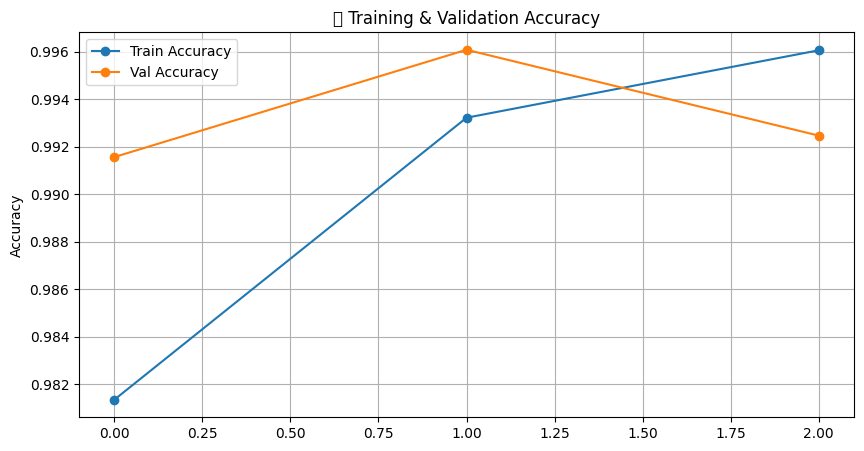

✅ Accuracy plot displayed successfully.



C:\Users\K1taru\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


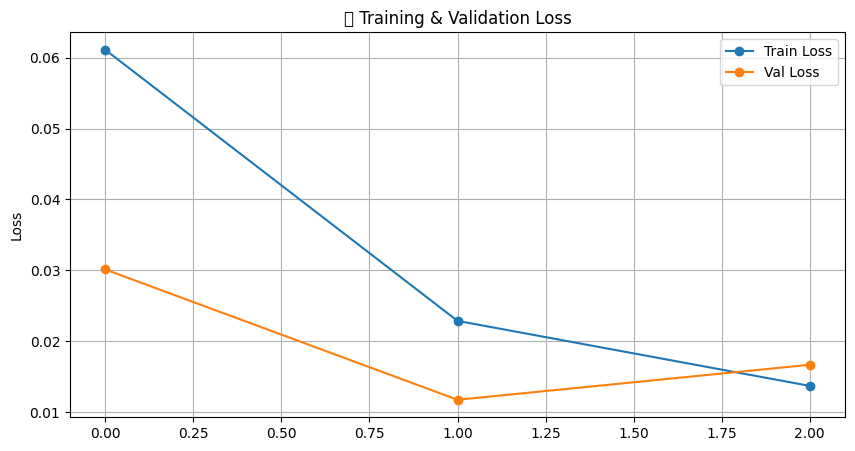

✅ Loss plot displayed successfully.



In [17]:
# --- Accuracy Plot ---
plt.figure(figsize=(10, 5))
plt.plot(history["train_acc"], label="Train Accuracy", marker='o')
plt.plot(history["val_acc"], label="Val Accuracy", marker='o')
plt.title("📈 Training & Validation Accuracy")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()
print("✅ Accuracy plot displayed successfully.\n")

# --- Loss Plot ---
plt.figure(figsize=(10, 5))
plt.plot(history["train_loss"], label="Train Loss", marker='o')
plt.plot(history["val_loss"], label="Val Loss", marker='o')
plt.title("📉 Training & Validation Loss")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()
print("✅ Loss plot displayed successfully.\n")


### Confusion Matrix

A confusion matrix provides a more detailed view of classification results.
It shows how many times the model correctly predicted each class versus how many times it confused it with another.

🔍 Collecting model predictions on test set...
✅ Predictions collected successfully.
🎯 Overall Accuracy: 99.43%
🏆 Best performing class: 'Apple' with 100.00% accuracy
⚠️  Worst performing class: 'Grapes' with 97.97% accuracy
🔄 Most confused pair: 'Grapes' ↔ 'Mango' (16 misclassifications)


<Figure size 800x600 with 0 Axes>

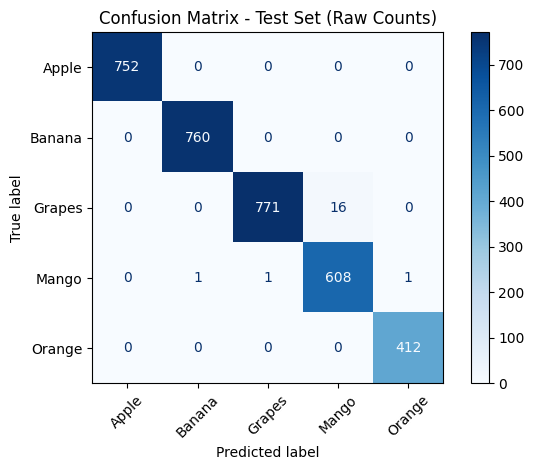


📊 Classification Report Summary:
              precision    recall  f1-score   support

       Apple       1.00      1.00      1.00       752
      Banana       1.00      1.00      1.00       760
      Grapes       1.00      0.98      0.99       787
       Mango       0.97      1.00      0.98       611
      Orange       1.00      1.00      1.00       412

    accuracy                           0.99      3322
   macro avg       0.99      0.99      0.99      3322
weighted avg       0.99      0.99      0.99      3322



In [18]:
# 📊 Collect predictions
print("🔍 Collecting model predictions on test set...")
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("✅ Predictions collected successfully.")

# 🧮 Compute confusion matrix (not normalized)
cm = confusion_matrix(all_labels, all_preds)
class_names = full_dataset.classes

# ✅ Compute overall accuracy
accuracy = np.trace(cm) / np.sum(cm)
print(f"🎯 Overall Accuracy: {accuracy * 100:.2f}%")

# ✅ Compute per-class accuracy
per_class_acc = cm.diagonal() / cm.sum(axis=1)
best_class_idx = np.argmax(per_class_acc)
worst_class_idx = np.argmin(per_class_acc)
print(f"🏆 Best performing class: '{class_names[best_class_idx]}' with {per_class_acc[best_class_idx]*100:.2f}% accuracy")
print(f"⚠️  Worst performing class: '{class_names[worst_class_idx]}' with {per_class_acc[worst_class_idx]*100:.2f}% accuracy")

# ✅ Identify the most confused class pair (excluding diagonal)
cm_copy = cm.copy().astype(float)
np.fill_diagonal(cm_copy, 0)
most_confused_idx = np.unravel_index(np.argmax(cm_copy), cm_copy.shape)
most_confused_pair = (class_names[most_confused_idx[0]], class_names[most_confused_idx[1]])
most_confused_value = int(cm_copy[most_confused_idx])
print(f"🔄 Most confused pair: '{most_confused_pair[0]}' ↔ '{most_confused_pair[1]}' ({most_confused_value} misclassifications)")

# 📈 Optional: show confusion matrix plots
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation=45, colorbar=True)
plt.title("Confusion Matrix - Test Set (Raw Counts)")
plt.tight_layout()
plt.show()

# 📄 Optional: classification report summary
print("\n📊 Classification Report Summary:")
print(classification_report(all_labels, all_preds, target_names=class_names, digits=2))
